In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cifar10
from utils import plot_images, read_mnist_data
from tfops import fc, conv, deconv, flatten, inflate
from time import time
from os.path import exists

In [5]:
cifar10.maybe_download_and_extract()

data_train, cls_train, _ = cifar10.load_training_data()
data_test, cls_test, _ = cifar10.load_test_data()

Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [22]:
tf.reset_default_graph()

z_dim = 128

with tf.name_scope('inputs'):
    x_image = tf.placeholder(tf.float32, (None, 32, 32, 3), 'x')
    noise = tf.placeholder(tf.float32, (None, z_dim), name='noise')
    
with tf.name_scope('encoder'):
    z = conv(x_image, 16)
    z = conv(z, 32)
    z = flatten(z)
    with tf.name_scope('latent-space'):
        z_mean = fc(z, z_dim, 'None', 'z_mean')
        z_std = fc(z, z_dim, 'None', 'z_std')
        z = noise * z_std + z_mean
    
with tf.name_scope('decoder'):
    x_gen = fc(z, 32 * 8 * 8)
    x_gen = inflate(x_gen, (8, 8))
    x_gen = deconv(x_gen, 16, out_shape=(-1, 16, 16, -1))
    x_gen = deconv(x_gen, 3, out_shape=(-1, 32, 32, -1), activation='sigmoid')

with tf.name_scope('optimizer'):
    generation_loss = tf.reduce_mean((x_gen - x_image)**2, name='generation_loss')
    tf.summary.scalar('generation_loss', generation_loss)
    
    latent_loss = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_std) - tf.log(tf.square(z_std)) - 1, 1)
    tf.summary.scalar('latent_loss', tf.reduce_mean(latent_loss))
    
    loss = generation_loss + 1e-4 * latent_loss
    tf.summary.scalar('loss', generation_loss + 1e-4 * tf.reduce_mean(latent_loss))
    
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)
    
summ = tf.summary.merge_all()

In [7]:
def plot_reconstructions(sess, category=None, std=0, bw=(0, 1)):
    if category:
        cls_idx = np.where(cls_test == category)[0]
        data_test_cls = data_test[cls_idx, :, :, :]
    else:
        data_test_cls = data_test[:, :, :, :]
    
    img_idx = np.random.randint(0, len(data_test_cls), 11)
    valid_img = data_test_cls[img_idx, :, :, :] * (1 + np.random.randn(11, 32, 32, 3) * std)
    valid_img_reconstruction = sess.run(x_gen, {x_image: valid_img, noise: np.random.randn(11, z_dim)})
    plot_images(valid_img)
    
    valid_img_reconstruction[valid_img_reconstruction >= bw[1]] = 1
    valid_img_reconstruction[valid_img_reconstruction < bw[0]] = 0
    plot_images(valid_img_reconstruction)

In [8]:
def plot_generated_images(sess):
    epsilon = np.random.randn(11, z_dim)
    generated_img = sess.run(x_gen, {z: epsilon})
    plot_images(generated_img)

In [9]:
batch_size = 64
def optimize(epochs=1, category=None):
    if category:
        cls_idx = np.where(cls_train == category)[0]
        data_train_cls = data_train[cls_idx, :, :, :]
    else:
        data_train_cls = data_train[:, :, :, :]
        
    batches_per_epoch = int(len(data_train_cls) / batch_size)
    start_time = time()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter('output/DCVAE-CIFAR10')
        writer.add_graph(tf.get_default_graph())
        
        saver = tf.train.Saver()
        
        for epoch in range(epochs):
            for i in range(batches_per_epoch):
                x_batch = data_train_cls[np.random.choice(len(data_train_cls), batch_size, replace=False), :, :, :]
                epsilon = np.random.randn(batch_size, z_dim)
                sess.run(optimizer, {x_image: x_batch, noise: epsilon})
                
                print("{} / {} ({}%) -- {}s".format(epoch + 1, epochs, int(((i+1)/(batches_per_epoch * epochs) + epoch/epochs) * 100), np.round(time()-start_time, 2)), end='\r')
                
                if i % 100 == 0:
                    writer.add_summary(sess.run(summ, {x_image: x_batch, noise: epsilon}), global_step=epoch * batches_per_epoch + i)
                
            plot_reconstructions(sess, category)

        writer.close()
        total_time = time() - start_time
        print("Time per epoch: {}s, Time per iteration: {}s, Time per example: {}s".format(total_time / epochs, total_time / (epochs * batches_per_epoch), total_time / (epochs * batches_per_epoch * batch_size)))
        
        saver.save(sess, 'checkpoints/DCVAE-CIFAR10/DCVAE-CIFAR10', write_meta_graph=False)

INFO:tensorflow:Restoring parameters from checkpoints/DCVAE-CIFAR10/DCVAE-CIFAR10
Reconstructions:


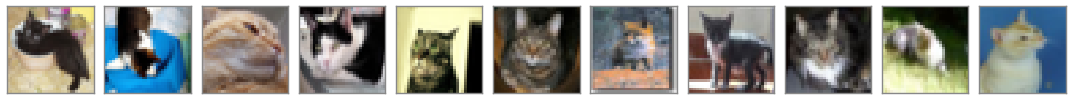

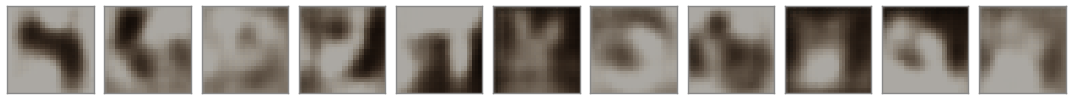

Generation:


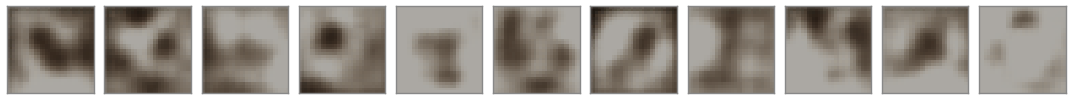

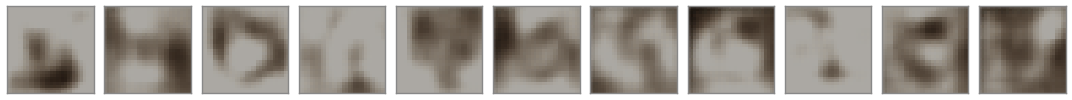

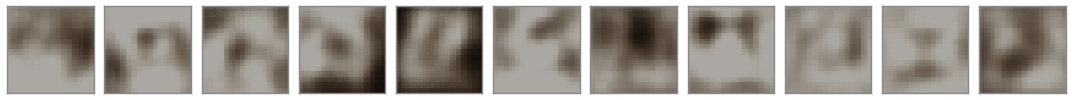

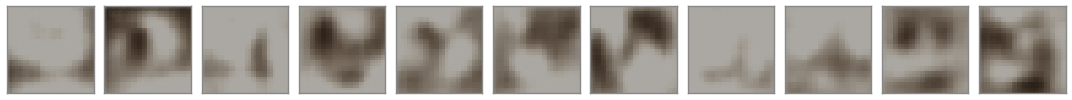

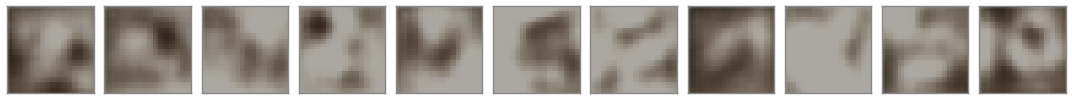

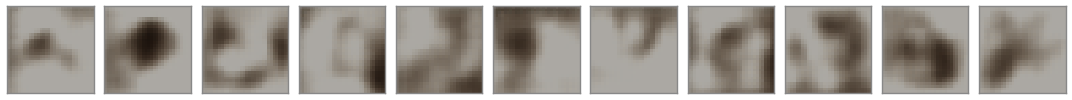

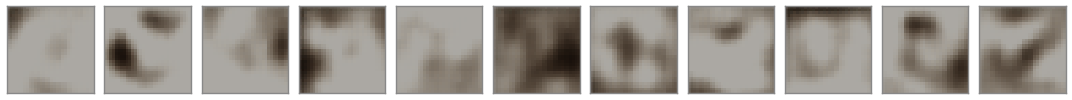

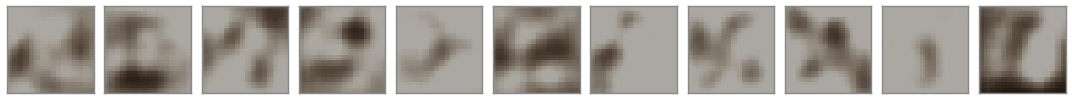

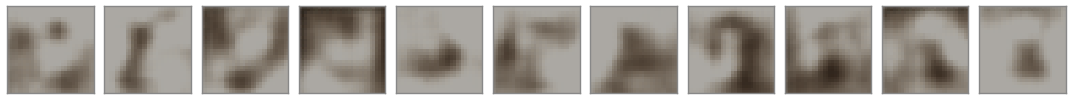

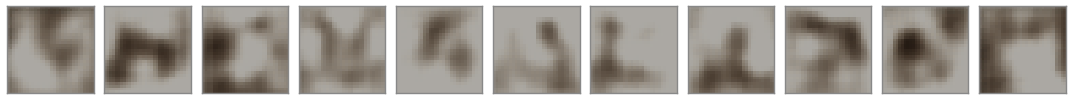

In [24]:
if exists('checkpoints/DCVAE-CIFAR10/DCVAE-CIFAR10.data-00000-of-00001'):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, 'checkpoints/DCVAE-CIFAR10/DCVAE-CIFAR10')
        
        print("Reconstructions:")
        plot_reconstructions(sess, 3)
        
        print("Generation:")
        for _ in range(10):
            plot_generated_images(sess)
else:
    optimize(100, 3)